In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
g = 9.81
z = 257.4 * 0.001
Tc = np.sqrt(z/g)
# supporting duration
T_sup = 0.6

In [3]:
def calc_basic_passing_foot_pos(v, T_sup):
    return Tc*v * (np.cosh(T_sup/Tc)-1) / np.sinh(T_sup/Tc)
def calc_basic_unpassing_foot_pos(v, T_sup):
    return Tc*v * (np.cosh(T_sup/Tc)+1) / np.sinh(T_sup/Tc)

def calc_y_vel(y0, T_sup):
    return (y0/Tc) * ( np.sinh(T_sup/Tc) / ( -1 - np.cosh(T_sup/Tc) ) )

In [143]:
def calc_LIP_p(t, cp0, cv0):
    x_t = cp0[0] * np.cosh(t/Tc) + Tc * cv0[0] * np.sinh(t/Tc)
    y_t = cp0[1] * np.cosh(t/Tc) + Tc * cv0[1] * np.sinh(t/Tc)
    return [x_t, y_t]

def calc_LIP_v(t, cp0, cv0):
    vx_t = cp0[0] / Tc * np.sinh(t/Tc) + cv0[0] * np.cosh(t/Tc)
    vy_t = cp0[1] / Tc * np.sinh(t/Tc) + cv0[1] * np.cosh(t/Tc)
    return [vx_t, vy_t]

def calc_LIP_com(T_sup, cp0, cv0):
    n = int(T_sup / 0.01) + 1

    traj = []

    for i in range(n):
        t = i * 0.01
        pos = calc_LIP_p(t, cp0, cv0)
        traj.append(pos)

    return traj

In [144]:
def calc_rot_angle_limit(cvn_last):
    # return 0 for too small vel
    if abs(cvn_last[0]) < 0.005 or abs(cvn_last[1]) < 0.005:
        return [0,0]

    a1 = np.arctan2(cvn_last[1], cvn_last[0])
    y_v_lim = 0.03 / Tc
    cv_mag = np.sqrt(cvn_last[0]**2 + cvn_last[1]**2)
    if cv_mag < y_v_lim: # if no concerns to pass the pivot
        a2 = 0.5
    else:
        a2 = np.arccos(y_v_lim / np.sqrt(cvn_last[0]**2 + cvn_last[1]**2))
    a2 = a2 * -1 * (a1/abs(a1))

    # reduce angle limits
    a1*=0.3
    a2*=0.3

    angle_limits = []
    if a1 > a2:
        angle_limits = [a1, a2]
    else:
        angle_limits = [a2, a1]
    # print("angle_limits:", angle_limits)
    return angle_limits

def rotate_vec(vec, angle):
    c = np.cos(angle)
    s = np.sin(angle)
    R = np.array([[c, -s],
                  [s,  c]])
    vec_rot = R @ np.array(vec)
    return vec_rot.tolist()

In [164]:
kpx = 0.01
kdx = 0.001

kpy = 0.01
kdy = 0.001

def px_pid(cvn_last, cvn_m1_last, vd):
    # print(f"cvn_m1_last: {cvn_m1_last}, cvn_last: {cvn_last}")
    err = vd[0]-cvn_last[0]
    derr = -cvn_last[0] + cvn_m1_last[0]
    # print(f"vel err: {err}, d_err: {derr}")

    px = calc_basic_passing_foot_pos(cvn_last[0], T_sup)
    # print("basic foot pos x:", px)

    px_r = px - kpx * err - kdx * derr

    # print("corrected foot pos x:", px_r)
    return px_r

def py_pid(cvn_last, cvn_m1_last, vd, pn, T_sup):
    # print(f"cvn_m1_last: {cvn_m1_last}, cvn_last: {cvn_last}")
    vd_sum = calc_y_vel(0.03 * -pn[1]/abs(pn[1]), T_sup) + vd[1]
    err = vd_sum + cvn_last[1]
    derr = -cvn_last[1] - cvn_m1_last[1]
    # print(f"vd_sum: {vd_sum}, vel err: {err}, d_err: {derr}")

    py = calc_basic_unpassing_foot_pos(cvn_last[1], T_sup)
    # print("basic foot pos y:", py)

    py_r = py - kpy * err - kdy * derr

    # print("corrected foot pos y:", py_r)
    return py_r

In [180]:
# com, pn: com and foot position from current foot position
cpn_last = [0, -0.03]
cvn_last = []

pn = [0,-0.03]

cvn_m1_last = [0, calc_y_vel(-pn[1], T_sup)]
cvn_last = calc_LIP_v(T_sup, [-pn[0], -pn[1]], cvn_m1_last)
print(cvn_last)

[0.0, 0.1763032118276362]


In [181]:
vd = [0.05, 0.0, 1]

foot_pos = []
traj_history = []

for i in range(35):
    if i < 8:
        vd = [0.1, 0.00, 0.5]
    elif i < 16:
        vd = [0.15, -0.05, -0.5]
    elif i < 24:
        vd = [-0.1, 0.05, -0.3]
    else:
        vd = [-0.1, -0.05, 0.3]

    # decide angle
    angle_limits = calc_rot_angle_limit(cvn_last)
    rotation = vd[2]
    if rotation > 0:
        rotation = angle_limits[0] * abs(rotation)
    else:
        rotation = angle_limits[1] * abs(rotation)
    # rotate vel
    cvn_last = rotate_vec(cvn_last, rotation)

    # decide pn_p1
    px_p1 = px_pid(cvn_last, cvn_m1_last, vd)
    py_p1 = py_pid(cvn_last, cvn_m1_last, vd, pn, T_sup)
    pn_p1 = [px_p1, py_p1, rotation]
    # print("next foot pos pn_p1:", pn_p1)
    foot_pos.append(pn_p1)

    # calculate COM trajectory
    # from: n step com last, pivot: pn_p1
    cp0 = [-pn_p1[0], -pn_p1[1]]
    cv0 = cvn_last
    traj = calc_LIP_com(T_sup, cp0, cv0)
    traj_history.append(traj)

    # update com and p
    pn = pn_p1
    cvn_m1_last = cvn_last
    cpn_last = calc_LIP_p(T_sup, cp0, cv0)
    cvn_last = calc_LIP_v(T_sup, cp0, cv0)
    # print("next com pos:", cpn_last)
    # print("next com vel:", cvn_last)
    # print("-------------------")


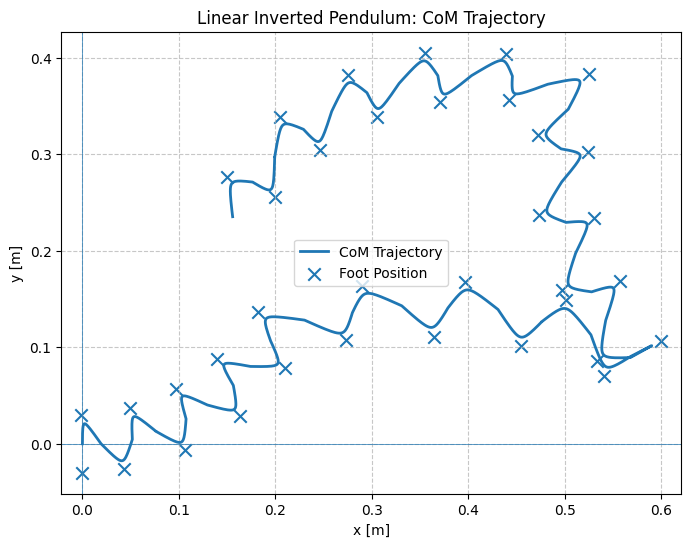

In [182]:
angle = 0.0
foot_all = [[0,-0.03]]
traj_all = []
traj_last = [0,0]
for i in range(len(foot_pos)):
    angle += foot_pos[i][2]
    # convert to world coordinate
    foot_pos_rot = rotate_vec([foot_pos[i][0], foot_pos[i][1]], angle)
    pivot = [0,0]
    pivot[0] = foot_pos_rot[0] + traj_last[0]
    pivot[1] = foot_pos_rot[1] + traj_last[1]

    traj = traj_history[i]
    for pos in traj:
        pos = rotate_vec(pos, angle)
        traj_all.append([pos[0]+pivot[0], pos[1]+pivot[1]])
    traj_last = traj_all[-1]
    foot_all.append(pivot)

# CoM trajectory
x_coords = [pos[0] for pos in traj_all]
y_coords = [pos[1] for pos in traj_all]

# Foot positions
foot_x = [pos[0] for pos in foot_all]
foot_y = [pos[1] for pos in foot_all]

# 2. グラフの設定
plt.figure(figsize=(8, 6))

# CoM
plt.plot(x_coords, y_coords,
         label='CoM Trajectory',
         linewidth=2)

# Foot (pivot)
plt.scatter(foot_x, foot_y,
            marker='x',
            s=80,
            label='Foot Position')

# 3. 装飾
plt.title('Linear Inverted Pendulum: CoM Trajectory')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axhline(0, linewidth=0.5)
plt.axvline(0, linewidth=0.5)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.axis('equal')

# 4. 表示
plt.show()
